## Data Visulization

##### Imoport the require package

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month
from os.path import abspath
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from windrose import WindroseAxes

In [13]:
warehouse_location = abspath('spark-warehouse')

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

table_path = "spark-warehouse/mydb.db/weather_data_partitioned_by_month"
df = spark.read.format("parquet").load(table_path)
df.head()



24/12/23 12:44:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Row(date='2021-07-01', time='12:50:00', water_content=0.31439998745918274, solar_radiation=818.5, rain=0.0, temperature=35.63999938964844, rh=59.5, wind_speed=0.30000001192092896, gust_speed=1.7000000476837158, wind_direction=132.0, dew_point=26.549999237060547, year_month='2021-7')

In [14]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content: float (nullable = true)
 |-- solar_radiation: float (nullable = true)
 |-- rain: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- rh: float (nullable = true)
 |-- wind_speed: float (nullable = true)
 |-- gust_speed: float (nullable = true)
 |-- wind_direction: float (nullable = true)
 |-- dew_point: float (nullable = true)
 |-- year_month: string (nullable = true)



In [15]:
df = df.toPandas()

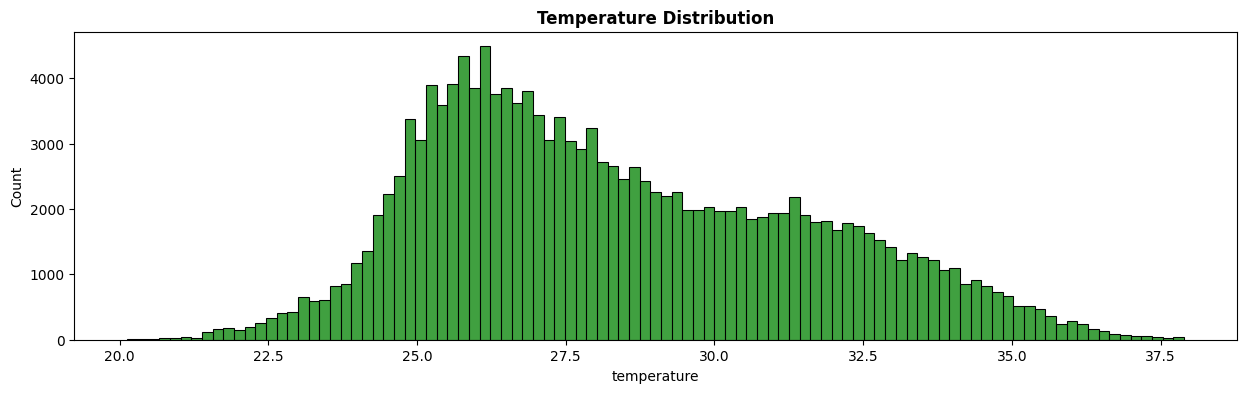

In [16]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 4))

# Temperature
sns.histplot(df.temperature, kde=False, color="g").set_title('Temperature Distribution')

plt.title("Temperature Distribution", fontweight='bold')
plt.show()


In [17]:
solar_tem = df[['time','solar_radiation', 'temperature']]
#trigger on solar 
solar_tem['shift'] = solar_tem['solar_radiation'].apply(lambda x : "Night" if x == 1 else "Day")
solar_tem.head(10)


/tmp/ipykernel_101659/2883415360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_tem['shift'] = solar_tem['solar_radiation'].apply(lambda x : "Night" if x == 1 else "Day")


,time,solar_radiation,temperature,shift
0,12:50:00,818.5,35.639999,Day
1,23:00:00,1.0,27.750000,Night
2,06:45:00,137.0,28.990000,Day
3,17:40:00,39.0,30.370001,Day
4,11:25:00,253.0,32.639999,Day
5,04:40:00,1.0,25.620001,Night
6,02:30:00,1.0,24.680000,Night
7,18:50:00,1.0,25.820000,Night
8,14:55:00,406.0,31.660000,Day
9,15:45:00,538.0,31.049999,Day


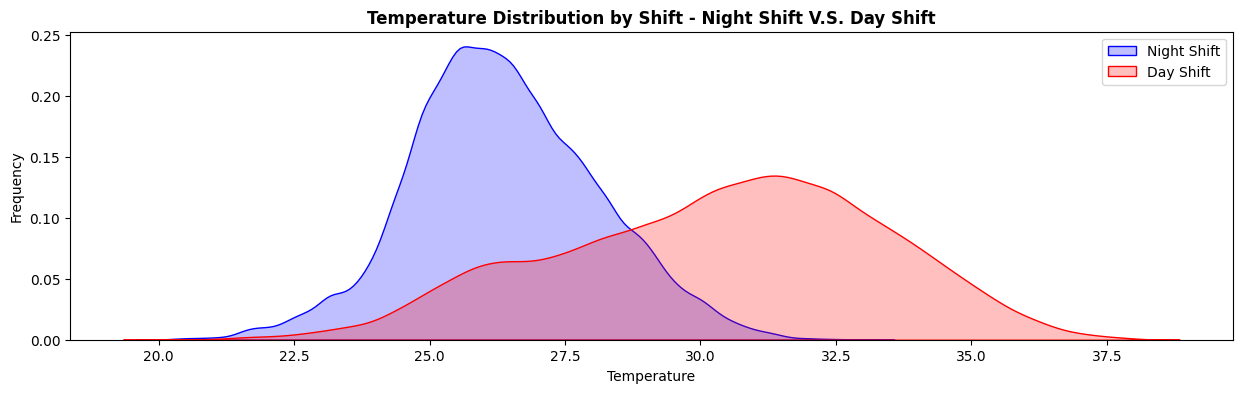

In [18]:
# Assuming solar_tem is a PySpark DataFrame
  # Convert to pandas DataFrame

# KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15, 4))
ax = sns.kdeplot(
    solar_tem.loc[solar_tem['shift'] == "Night", 'temperature'],
    color='b',
    fill=True, 
    label='Night Shift'
)
ax = sns.kdeplot(
    solar_tem.loc[solar_tem['shift'] == "Day", 'temperature'],
    color='r',
    fill=True,
    label='Day Shift'
)
ax.set(xlabel='Temperature', ylabel='Frequency')
plt.legend()
plt.title('Temperature Distribution by Shift - Night Shift V.S. Day Shift', fontweight='bold')
plt.show()


##### Show the unique year in our dataframe

In [19]:
df['date'] = pd.to_datetime(df['date'])

unique_years = df['date'].dt.year.unique()
unique_years.sort()
print(unique_years)

[2020 2021 2022]


##### Classify the wind pattern as windrose by each years 

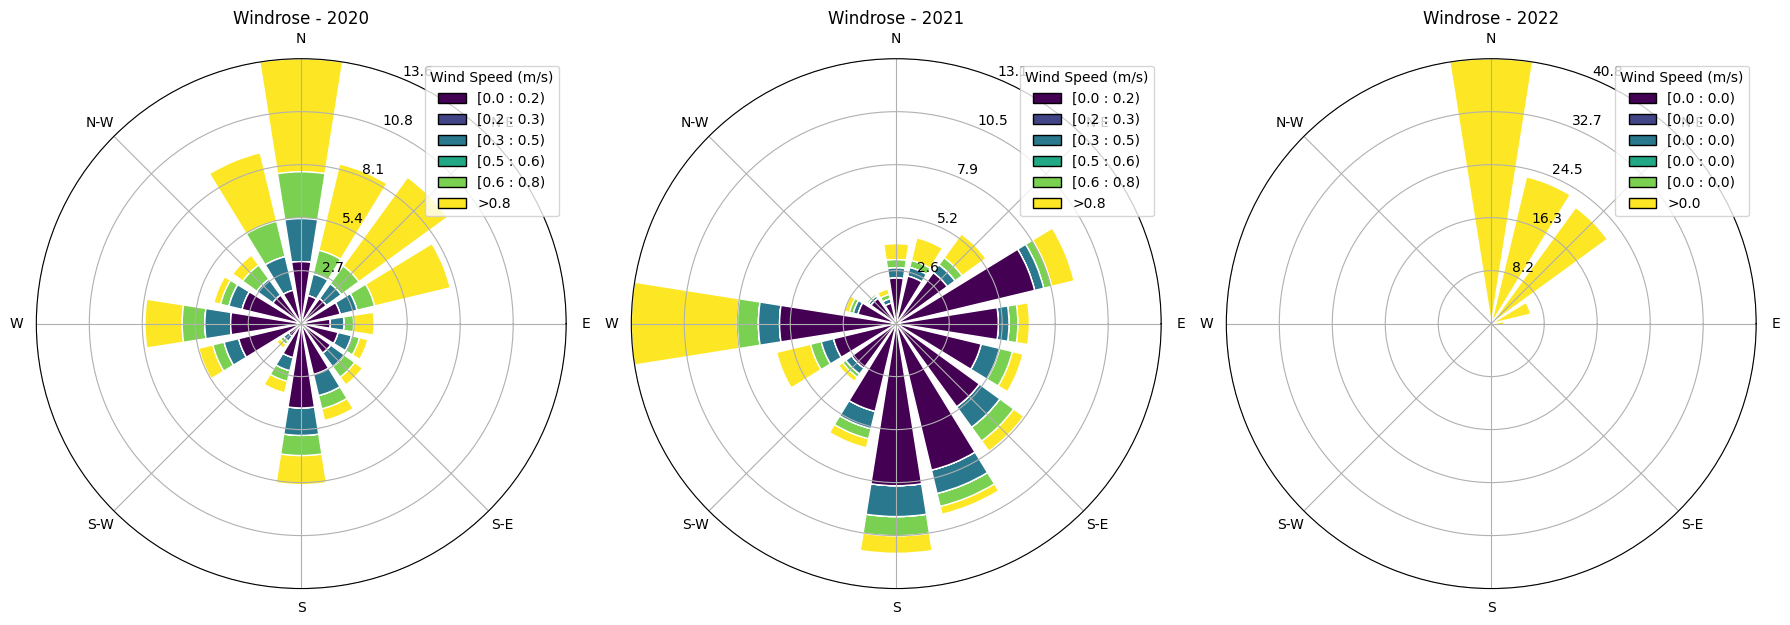

In [20]:
# Assuming 'df' is your Pandas DataFrame
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is datetime
df['year'] = df['date'].dt.year          # Extract year

# Create a figure for 3 plots in a row
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection='windrose'), figsize=(18, 6))

for i, year in enumerate(unique_years):
    # Filter data for the specific year
    specific_year_df = df[df['year'] == year]
    
    # Extract wind speed and direction
    wind_speed = specific_year_df['wind_speed']
    wind_direction = specific_year_df['wind_direction']
    
    # Plot the windrose for this year
    ax = axes[i]
    ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f"Windrose - {year}", fontsize=12)
    ax.legend(title="Wind Speed (m/s)", loc="best")

# Adjust layout
plt.tight_layout()
plt.show()


##### Plot each month in 2020

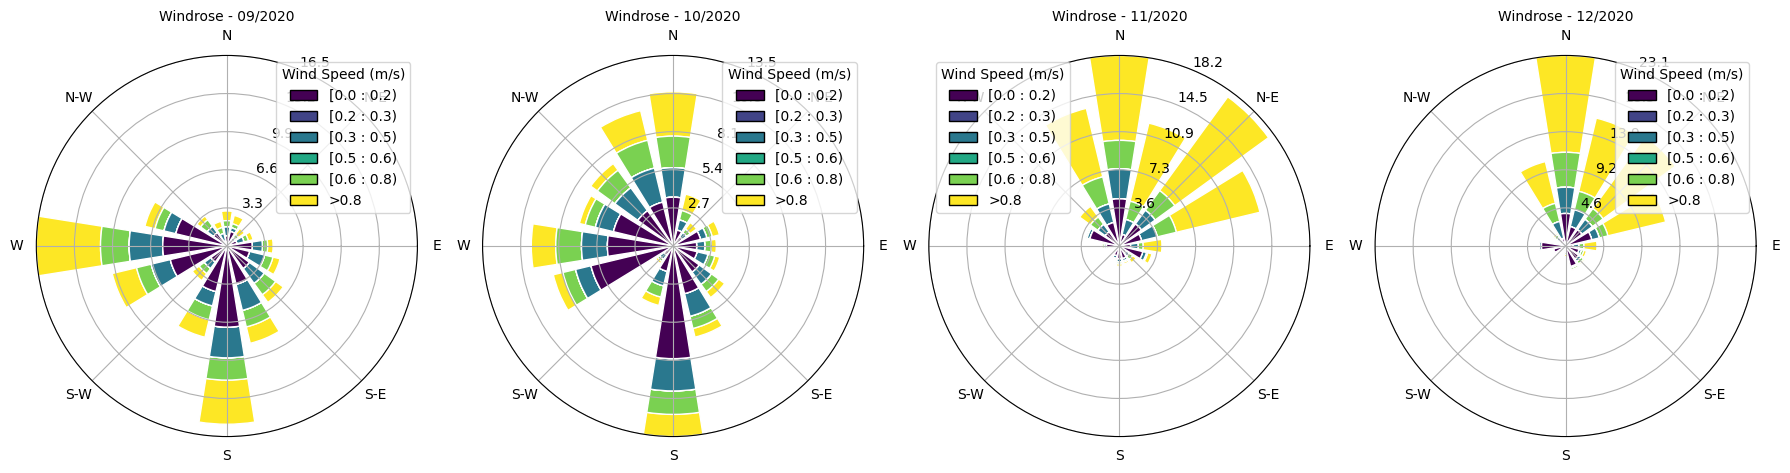

In [29]:


# Assuming 'df' is your DataFrame
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is datetime
df['year'] = df['date'].dt.year          # Extract year
df['month'] = df['date'].dt.month        # Extract month

# Filter data for the year 2020
df_2020 = df[df['year'] == 2020]

# Get the unique months in the dataset
unique_months = sorted(df_2020['month'].unique())

# Determine the number of unique months
n_months = len(unique_months)

n_rows = (n_months + 3) // 4 
fig, axes = plt.subplots(n_rows, 4, subplot_kw=dict(projection='windrose'), figsize=(18, 6 * n_rows))

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate over the unique months
for i, month in enumerate(unique_months):
    # Filter data for the specific month
    specific_month_df = df_2020[df_2020['month'] == month]
    
    # Extract wind speed and direction
    wind_speed = specific_month_df['wind_speed']
    wind_direction = specific_month_df['wind_direction']
    
    # Plot the windrose for this month
    ax = axes[i]
    ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f"Windrose - {month:02d}/2020", fontsize=10)
    ax.legend(title="Wind Speed (m/s)", loc="best")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


##### Plot each month in 2021

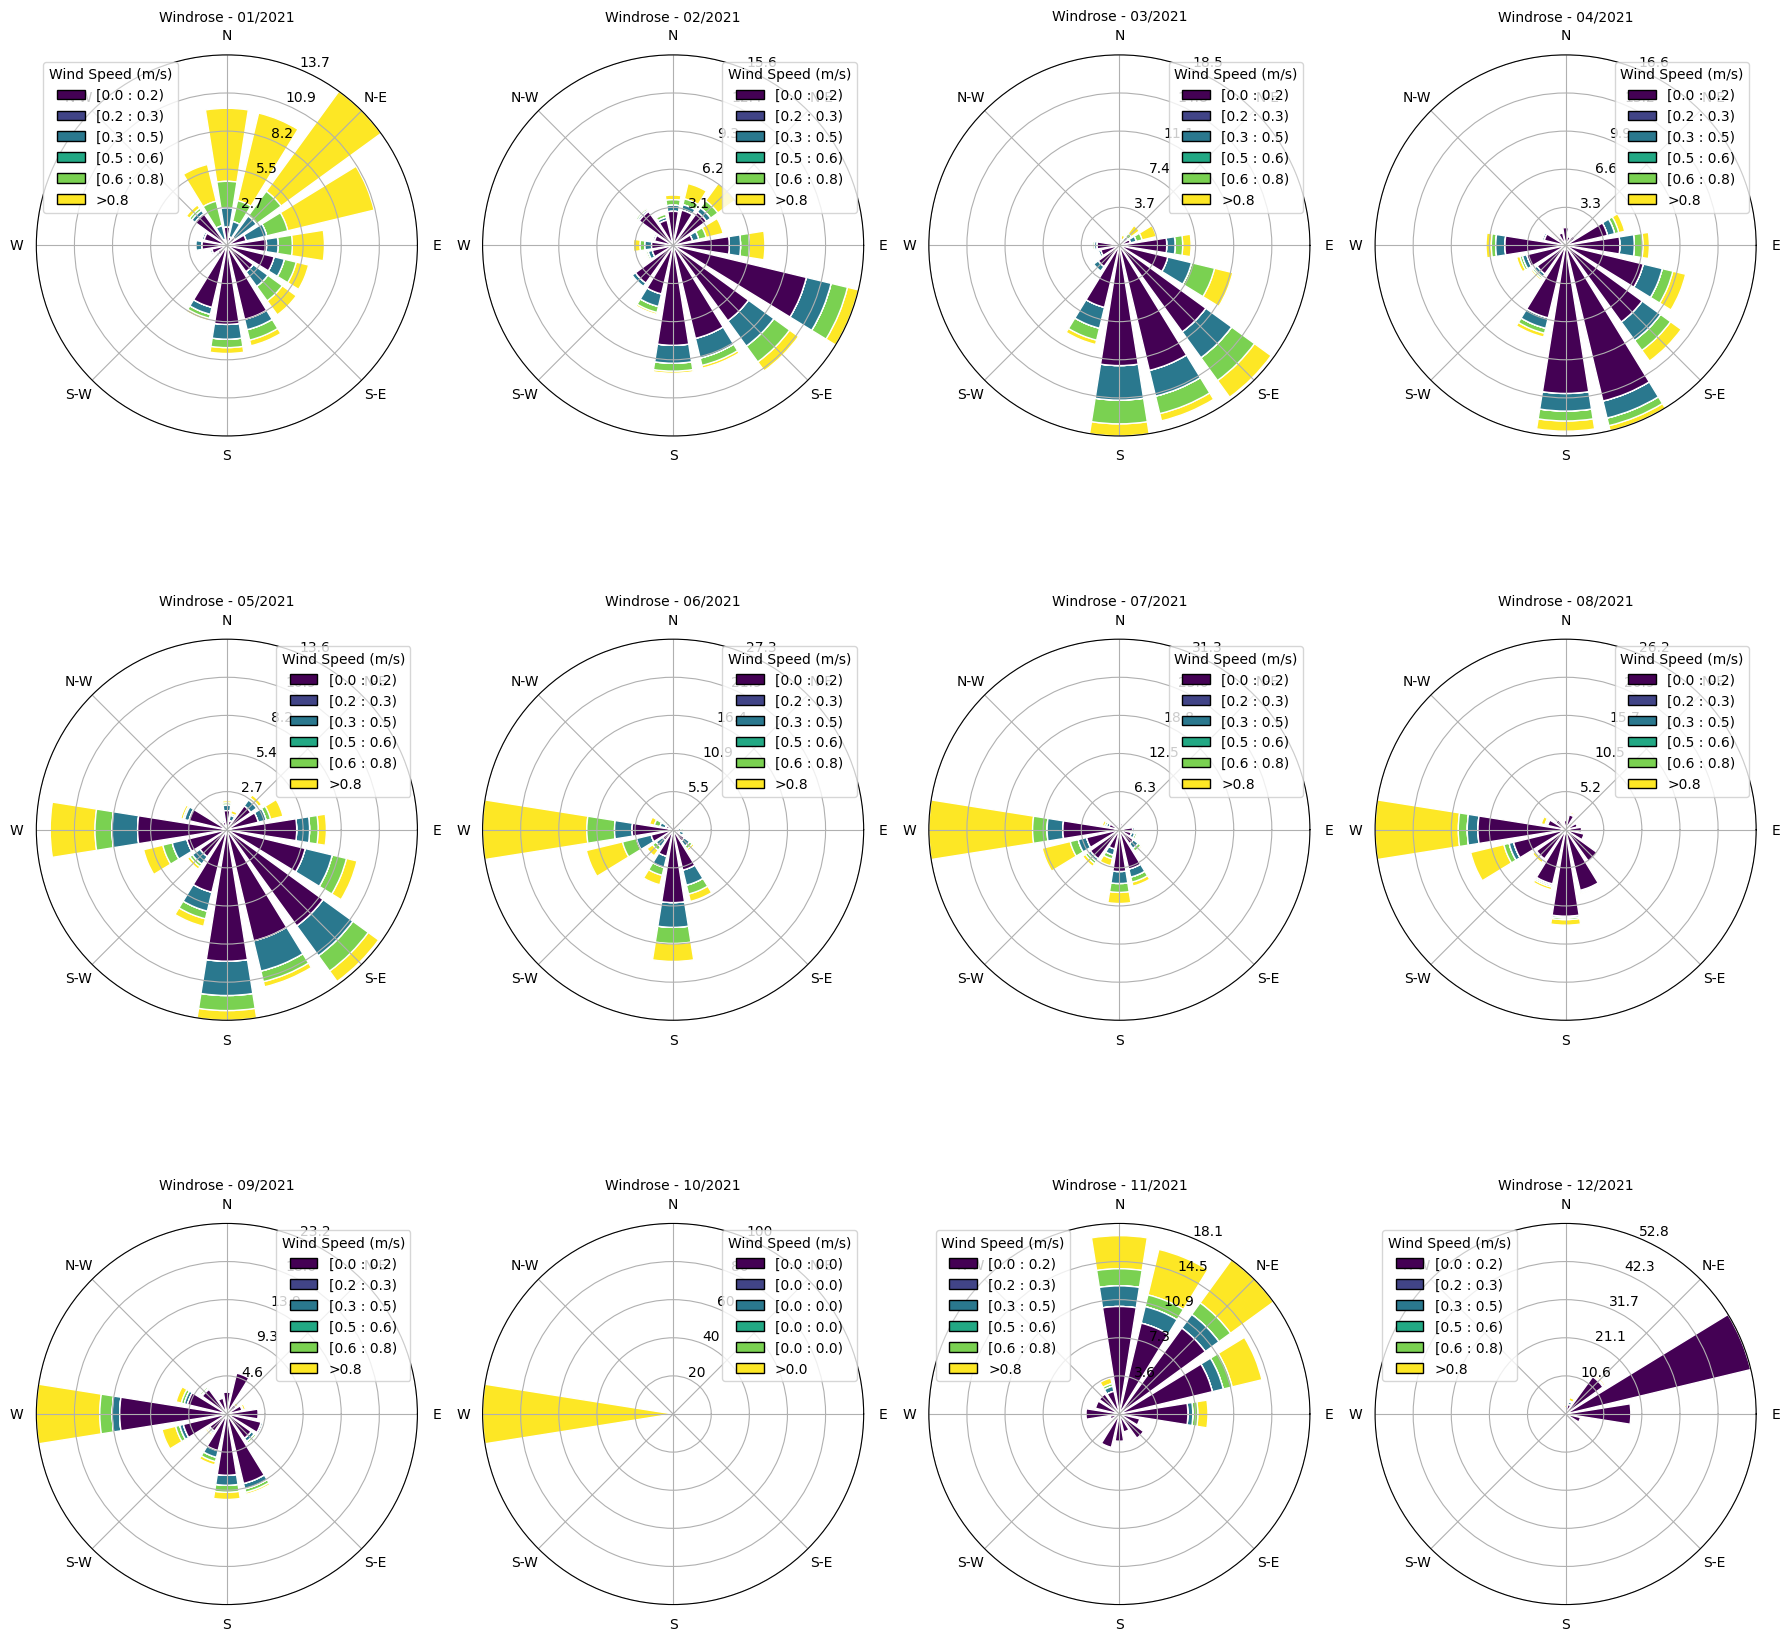

In [30]:
# Assuming 'df' is your DataFrame
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is datetime
df['year'] = df['date'].dt.year          # Extract year
df['month'] = df['date'].dt.month        # Extract month

# Filter data for the year 2021
df_2021 = df[df['year'] == 2021]

# Get the unique months in the dataset
unique_months = sorted(df_2021['month'].unique())

# Determine the number of unique months
n_months = len(unique_months)

n_rows = (n_months + 3) // 4 
fig, axes = plt.subplots(n_rows, 4, subplot_kw=dict(projection='windrose'), figsize=(18, 6 * n_rows))

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate over the unique months
for i, month in enumerate(unique_months):
    # Filter data for the specific month
    specific_month_df = df_2021[df_2021['month'] == month]
    
    # Extract wind speed and direction
    wind_speed = specific_month_df['wind_speed']
    wind_direction = specific_month_df['wind_direction']
    
    # Plot the windrose for this month
    ax = axes[i]
    ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f"Windrose - {month:02d}/2021", fontsize=10)
    ax.legend(title="Wind Speed (m/s)", loc="best")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()
